### The input is a file with format: timestamp, personId, x, y

In [1]:
import numpy as np
init_timestamp = 1436047260
beta = (60/55)*1000# in ms, according to the paper Freudiger 2015

In [2]:
def generate_first_moment_visible(crowd_size): #initialization      
    next_moment =[]
    for i in range(0, crowd_size):
        delay = np.random.exponential(beta)
        next_moment.append(int(init_timestamp  + delay))    
    return next_moment    

In [3]:
next_moment = generate_first_moment_visible(3)
next_moment

[1436048160, 1436047505, 1436049677]

In [30]:
def gen_next_moment(timestamp_now): # next moment is drawn from exponential(1/beta) distribution
    delay = np.random.exponential(beta)
    return int(timestamp_now + delay) + 1# avoid 0

In [31]:
next_mom = gen_next_moment(3)

In [32]:
next_mom

93

In [18]:
def make_new_record(record, new_position, randomized):#record = [timestamp, personId, x, y], new_position = [x,y]
    sigma_x =  np.random.exponential(5)
    sigma_y =  np.random.exponential(5)
    new_record = {}
    new_record["measurementTimestamp"] = record[0]
    new_record["value"] = {}
    new_record["value"]["sourceMac"] = record[1]
    new_record["value"]["averagecoordinate"] = {}
    new_record["value"]["averagecoordinate"]["avg"] = {}
    new_record["value"]["averagecoordinate"]["avg"]["coordinates"] =[new_position[0], new_position[1], 0.0]
    new_record["value"]["averagecoordinate"]["error"] = {}
    new_record["value"]["averagecoordinate"]["error"]["coordinates"] = [sigma_x, sigma_y, 1000.0]
    new_record["trackeeHistory"]={}
    new_record["trackeeHistory"]["localMac"] = randomized
    return new_record

In [19]:
b = make_new_record([0,1,3,4], [5,6], 0)

In [20]:
b

{'measurementTimestamp': 0,
 'trackeeHistory': {'localMac': 0},
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [8.946253470062492, 20.48634093050381, 1000.0]}},
  'sourceMac': 1}}

In [21]:
def generate_randomized(crowd_size): #to be done
    randomized = [0 for i in range(0, crowd_size)]
    return randomized

In [22]:
randomized = generate_randomized(6)

In [23]:
randomized


[0, 0, 0, 0, 0, 0]

In [24]:
def draw_new_coordinate(position, modes_half_distance=10.0, sigma=5.0):
    rand_mode = np.random.rand()
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    mu = position + rand_mode*modes_half_distance
    new_pos = np.random.normal(mu, sigma)
    return new_pos
    

In [60]:
def create_teleportation_effect_single(record, modes_half_distance, sigma):            
        record_x = draw_new_coordinate(record[2], modes_half_distance, sigma)
        record_y = draw_new_coordinate(record[3], modes_half_distance, sigma)
        return [record_x, record_y]

In [67]:
def make_fake_data(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    next_moment = generate_first_moment_visible(crowd_size)
    randomized = generate_randomized(crowd_size)
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        for i in range(0, crowd_size):
            timestamp = record[0]
            #print(next_moment)
            if next_moment[i] == record[0]:#timestamp
                #print(next_moment)
                new_position = create_teleportation_effect_single(record, 20, 5)#[x,y]
                fake_record = make_new_record(record, new_position, randomized[i])
                fake_positions.append(fake_record)                
                next_moment[i] = gen_next_moment(record[0])
    return fake_positions            

In [68]:
def create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []    
    for timestamp in range(0, time_interval):
        for person in range(0, crowd_size):
            positions.append([init_timestamp+ timestamp, person, np.random.rand()*width_stadium, np.random.rand()* length_stadium])
    return positions 

In [69]:
crowd_size = 5
positions = create_positions(init_timestamp, crowd_size, 10*1000 , 105, 68)#this will come from Menge actually
beta = 3

In [70]:
positions[0]

[1436047260, 0, 103.98117980929023, 30.041955569595014]

In [71]:
fake_positions = make_fake_data(crowd_size, positions)

In [73]:
fake_positions

[{'measurementTimestamp': 1436047260,
  'trackeeHistory': {'localMac': 0},
  'value': {'averagecoordinate': {'avg': {'coordinates': [119.54507538160127,
      46.84606477113127,
      0.0]},
    'error': {'coordinates': [13.866950318604871,
      15.000216784904596,
      1000.0]}},
   'sourceMac': 0}},
 {'measurementTimestamp': 1436047261,
  'trackeeHistory': {'localMac': 0},
  'value': {'averagecoordinate': {'avg': {'coordinates': [102.36859442961205,
      44.75756881361378,
      0.0]},
    'error': {'coordinates': [1.3010983692202729,
      14.912481122964287,
      1000.0]}},
   'sourceMac': 0}},
 {'measurementTimestamp': 1436047261,
  'trackeeHistory': {'localMac': 0},
  'value': {'averagecoordinate': {'avg': {'coordinates': [58.30260732597932,
      82.27742356328602,
      0.0]},
    'error': {'coordinates': [3.960555910967918, 7.71753840996009, 1000.0]}},
   'sourceMac': 0}},
 {'measurementTimestamp': 1436047262,
  'trackeeHistory': {'localMac': 0},
  'value': {'averagecoordi

In [110]:
np.random.rand()

0.38013961524644735

In [4]:
#positions =  create_positions(10, 2, 105, 68)

In [ ]:
print(positions)

In [74]:
def create_teleportation_effect(positions, modes_distance, sigma):
    for record in positions:
        record[2] = draw_new_coordinate(record[2], modes_distance, sigma)
        record[3] = draw_new_coordinate(record[3], modes_distance, sigma)
    return positions    

In [79]:
positions = create_teleportation_effect(positions, 10, 5)
print(positions)

[[1436047260, 0, 89.55582077060474, -1.5761477267195332], [1436047260, 1, 95.72702334624856, 22.853120941024272], [1436047260, 2, 65.85913789850254, 60.62128268710112], [1436047260, 3, 23.44883780659479, 2.9361964838140757], [1436047260, 4, 31.18248854356402, 30.756871254580695], [1436047261, 0, 84.94793371388363, 82.60318644935847], [1436047261, 1, 13.621372229929529, -9.008413270771992], [1436047261, 2, 0.8723513593179, -11.88194915450914], [1436047261, 3, 80.31810295601858, 37.89851563682077], [1436047261, 4, 67.79161094824914, 0.4488310224481853], [1436047262, 0, 126.6133327762649, 40.22365591220285], [1436047262, 1, 74.31108245576243, 15.887354883144244], [1436047262, 2, 5.741130181109302, -7.727196814071144], [1436047262, 3, 16.538221485137452, 7.891533137332448], [1436047262, 4, 38.47051586260342, 10.025845509466247], [1436047263, 0, 49.929586748719714, 73.59744391602194], [1436047263, 1, 86.56095000987249, 61.634620556232846], [1436047263, 2, 68.53697646707799, 40.5495515710296

In [75]:
def get_a_snapshot(positions,  timestamp):
    snapshot = []    
    for position in positions:
        if position[0] == timestamp:
            snapshot.append(position)            
    return snapshot        

In [76]:
get_a_snapshot(positions, 0)

[]

In [77]:
def get_crowd_count_in_square(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y):
    snapshot = get_a_snapshot(positions,  timestamp)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_center - half_width_x and record[2] < x_center + half_width_x:
            if record[3] > y_center - half_length_y and record[3] < y_center + half_length_y:
                crowd_count +=1
    return crowd_count

In [59]:
def run(time_interval, width_stadium, length_stadium, square_half_size):
    errors = []
    differences = []
    scatter = []
    for crowd_size in range (1000, 100000, 500):
        positions = create_positions(crowd_size, time_interval, width_stadium, length_stadium)
        center_x = width_stadium/2.0
        center_y = length_stadium/2.0
        original_crowd_count = get_crowd_count_in_square(0, positions, crowd_size, center_x, center_y, square_half_size, square_half_size) 
        original_proportion = original_crowd_count/crowd_size
        positions = create_teleportation_effect(positions, 10, 5)
        new_crowd_count = get_crowd_count_in_square(0, positions, crowd_size, center_x, center_y, square_half_size, square_half_size)
        new_proportion = new_crowd_count/crowd_size
        diff= new_proportion-original_proportion
        differences.append(diff)
        error= new_crowd_count-original_crowd_count
        relative_error = error/(original_crowd_count)
        errors.append(relative_error)        
        scatter.append([original_crowd_count,relative_error ])
    lists = [errors, differences, scatter]    
    return lists  

In [60]:
lists = run(1, 105.0, 68.0, 5)

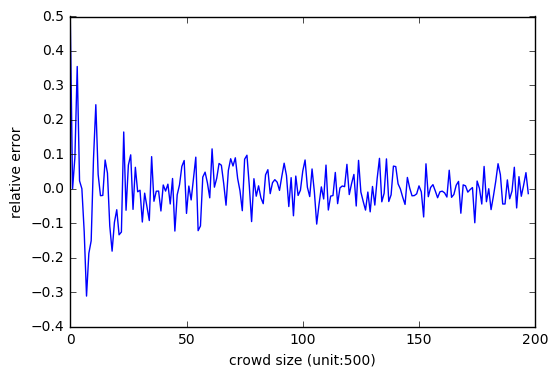

In [61]:
import matplotlib.pyplot as plt
plt.plot(lists[0])
plt.ylabel('relative error')
plt.xlabel('crowd size (unit:500)')
plt.show()

In [62]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

#n = 50

x = np.array([r[0] for r in lists[2] ])
y = np.array([r[1] for r in lists[2] ])

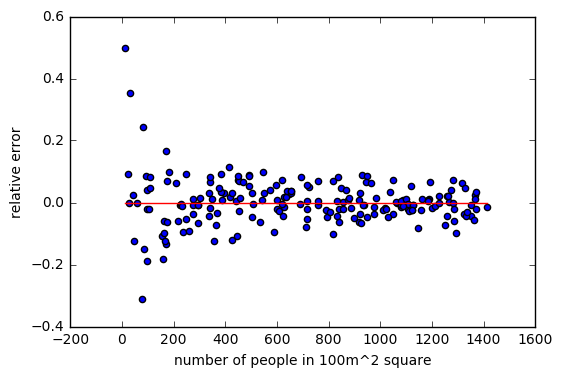

In [63]:
#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


#plt.plot(x, fit[0] * x + fit[1], color='red')
plt.plot(x, [0 for i in x], color='red')
plt.scatter(x, y)
plt.ylabel('relative error')
plt.xlabel('number of people in 100m^2 square')
axes = plt.gca()
#axes.set_xlim([0,360])
#axes.set_ylim([0,max(VisiblePerMinNonRandomized)])
plt.show()